In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsRegressor
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
mpl.rcParams.update({'font.size': 15})

The following code builds a single, multi-label classifier to predict ice/no ice condition on all panels of the airfoil.
Performances are evaluated with cross correlation. Function cross_val_score was not used as it only supports single label classifiers (I think)

Score can be selected by uncommenting the wanted SCORE variable. error is wrong predictions/all test samples (i.e. 1-accuracy)

https://stackoverflow.com/questions/37665680/how-does-sklearn-compute-the-accuracy-score-step-by-step

In [2]:
DATA = pd.read_excel('PTResults-1000.xlsx') # big dataset

param = DATA.iloc[:,1:6].to_numpy() # features
data = DATA.iloc[:, 6:].to_numpy()  # labels

nGroups = 10                   # number of groups
panels = DATA.iloc[4,6:].size # number of cells
nSamples = DATA.iloc[:,10].size
nK = 6                        # number of NN algorithms tried (NN1, NN3, NN5, NN7, NN9, NN11)
                              # the script trains one model for each

# select the score to plot    
# SCORE = 'precision'
# SCORE = 'recall'
# SCORE = 'f1'
SCORE = 'accuracy'
# SCORE = 'error'

# building 10 groups
ids = np.arange(nSamples)
np.random.shuffle(ids)

cellsPerGroup = int(nSamples/nGroups)
groups = np.empty([nGroups,int(cellsPerGroup)],dtype=int)

for i in range(nGroups):
    groups[i,:] = ids[i*cellsPerGroup : i*cellsPerGroup+cellsPerGroup]


# variable to store the score for each panel and each 
# NN algorithm (used to compute standard deviation)
str = np.empty([panels,nGroups,nK])
# variable to store the number of wrong predictions for each panel and each 
# NN algorithm
wrongPred = np.empty([panels,nGroups,nK])


# accumulation variable for score on each panel
errPanel = np.empty([panels,nK])
for i in range(panels):
    for j in range(nK):
        errPanel[i,j] = 0

# initialization of the classifiers
# NN1  = DecisionTreeClassifier()
NN1  = KNeighborsClassifier(n_neighbors=7)
NN3  = KNeighborsClassifier(n_neighbors=9)
NN5  = KNeighborsClassifier(n_neighbors=11)
NN7  = KNeighborsClassifier(n_neighbors=13)
NN9  = KNeighborsClassifier(n_neighbors=15)
NN11 = KNeighborsClassifier(n_neighbors=17)

labels = ['NN7','NN9','NN11','NN13','NN15','NN17']

counter = 0   # counts number of runs

# training models and computing errors w/ cross-validation. One group is used for testing 
# while the others are used for training. Repeat for all groups and average the error
for i in range(nGroups):
    
    counter = counter+1
    
    testIDs = groups[i,:]
    trainIDs = []

    for j in range(nGroups):
        if j != i:
            trainIDs.extend(groups[j,:])

    trainIDs = np.asarray(trainIDs, dtype=np.int)
            
    train_data = data[trainIDs,:]
    test_data  = data[testIDs,:]
    
    train_param = param[trainIDs,:]
    test_param  = param[testIDs,:]
    
    
    nTest  = test_data[:,1].size     # number of testing samples
    nTrain  = train_data[:,1].size     # number of training samples
    
    print("Run #",counter)
    
    # variable storing predicted labels for each NN algorithm
    pred = np.empty([nK,nTest,panels])

    # training a single classifier for all cells

    NN1.fit(train_param,train_data)
    pred[0,:,:] = NN1.predict(test_param)

    NN3.fit(train_param,train_data)
    pred[1,:,:] = NN3.predict(test_param)

    NN5.fit(train_param,train_data)
    pred[2,:,:] = NN5.predict(test_param)

    NN7.fit(train_param,train_data)
    pred[3,:,:] = NN7.predict(test_param)

    NN9.fit(train_param,train_data)
    pred[4,:,:] = NN9.predict(test_param)

    NN11.fit(train_param,train_data)
    pred[5,:,:] = NN11.predict(test_param)

    for i in range(nK):
        for p in range(panels):

            if SCORE == 'precision':
                sco = precision_score(test_data[:,p],pred[i,:,p])
            if SCORE == 'recall':
                sco = recall_score(test_data[:,p],pred[i,:,p])
            if SCORE == 'f1':
                sco = f1_score(test_data[:,p],pred[i,:,p])
            if SCORE == 'accuracy':
                sco = accuracy_score(test_data[:,p],pred[i,:,p])
            if SCORE == 'error':
#                 sco = (abs(pred[i,:,p] - test_data[:,p]).sum()  / nTest)  # same as 1 - accuracy_score (tested)
                sco = 1 - accuracy_score(test_data[:,p],pred[i,:,p])
                
            # storing (normalized) number of wrong predictions 
            wrongPred[p,counter-1,i] = (abs(pred[i,:,p] - test_data[:,p]).sum()  / nTest)
            
            # storing score
            str[p,counter-1,i] = sco
                                  
            errPanel[p,i] = errPanel[p,i] + sco

print("\n\n")

# print total number of miss classifications for each algorithm
totalMissClass = np.empty([nK])
for i in range(nK):
    totalMissClass[i] = wrongPred[:,:,i].sum() / (counter*panels) * 100
    print(labels[i]+' missclassified ',"%.3f" % totalMissClass[i],'% of the samples')


std = np.empty([panels,nK]) # standard deviation
for i in range(panels):
    if data[:,i].sum() == 0:
        errPanel[i,:] = 0
        std[i,:] = 0
    else:
        # computing error standard deviation at each panel
        for j in range(nK):
            std[i,j] = np.sqrt((1/counter)*((str[i,:,j]-errPanel[i,j]/counter)  * (str[i,:,j]-errPanel[i,j]/counter)).sum())

# error is plotted as %
errPanel = errPanel / counter * 100
std = std * 100

# reading header of xlsx file to get curvilinear cooridnates
CC = pd.read_excel('PTResults-1000.xlsx', header=None)
curv =  CC.iloc[0, 6:].to_numpy()
curv = np.array(curv,dtype=float) # matplotlib.pyplot.fill_between won't work w/o this line 

Run # 1
Run # 2
Run # 3
Run # 4
Run # 5
Run # 6
Run # 7
Run # 8
Run # 9
Run # 10



NN7 missclassified  5.435 % of the samples
NN9 missclassified  5.302 % of the samples
NN11 missclassified  5.309 % of the samples
NN13 missclassified  5.226 % of the samples
NN15 missclassified  5.202 % of the samples
NN17 missclassified  5.193 % of the samples


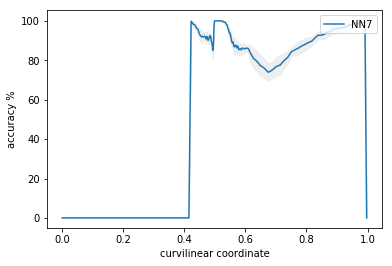

percentage of miss classifications at s = 0.61:  16.500




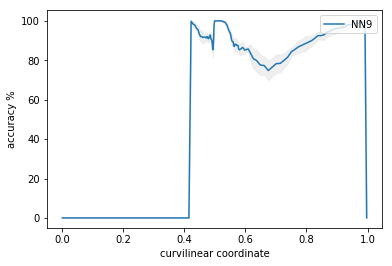

percentage of miss classifications at s = 0.61:  16.500




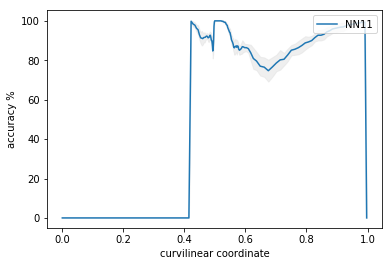

percentage of miss classifications at s = 0.61:  16.100




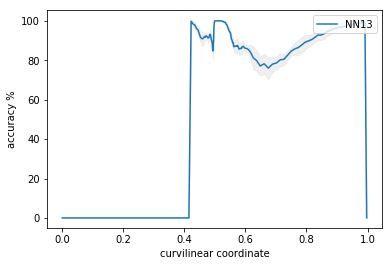

percentage of miss classifications at s = 0.61:  16.000




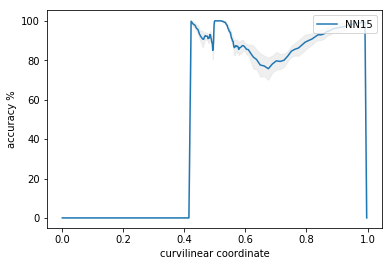

percentage of miss classifications at s = 0.61:  16.400




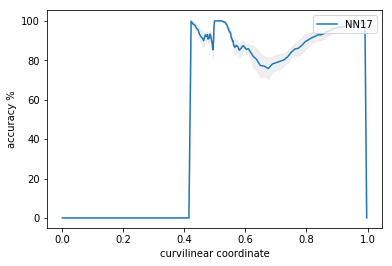

percentage of miss classifications at s = 0.61:  15.900




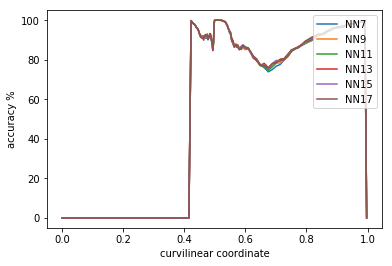

In [3]:
# plotting one figure for each NN algorithm
# x axis curvilinear coordinates
# y axis percentage of missed predictions averaged on all runs. Shaded area is standard deviation
# figure on the right shows histogramm at s = 0.6170...
target = 136 # s = 0.6170...

cs     = ['r','b','y','g','k','c']

# plt.rc('font',**{'family':'serif','serif':['Palatino']})
# plt.rc('text', usetex=True)

for i in range(nK):
    plt.figure()
    plt.plot(curv,errPanel[:,i],label=labels[i])  # error
    plt.fill_between(curv, errPanel[:,i]-std[:,i], errPanel[:,i]+std[:,i],  # fills area according to standard deviation
        alpha=0.5,color='#e0e0e0')
    plt.legend(loc='upper right')
    plt.xlabel('curvilinear coordinate')
    plt.ylabel(SCORE+' %')
    plt.savefig('kNN_c/'+labels[i]+SCORE+'.eps', format='eps')
    plt.show()
    print('percentage of miss classifications at s = 0.61: ',"%.3f" % (wrongPred[target,:,i].sum() / (nGroups) * 100))
    print('\n')


# plots single figure comparing all NN algo
plt.figure()
for i in range(nK):
    plt.plot(curv,errPanel[:,i],label=labels[i])

plt.legend(loc='upper right')
plt.xlabel('curvilinear coordinate')
plt.ylabel(SCORE+' %')
plt.savefig('kNN_c/NN_comp'+SCORE+'.eps', format='eps')
plt.show()